<h2><center style="font-size: 32px">Photons and baryons physics at high redshifts</center></h2>

In [1]:
from astropy.cosmology import FlatLambdaCDM
from astropy.modeling.models import BlackBody
from scipy.interpolate import interp1d
from astropy import constants as cst
from astropy import units as u
from scipy.integrate import quad
from scipy.integrate import simpson
from scipy.integrate import odeint
from scipy.optimize import fsolve
from scipy.optimize import root
import numpy as np
import matplotlib.pyplot as plt
#import AQN_module as aqn
#import AQN  #. this module in the Magneticum directory
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Natural $\longleftrightarrow$ physical units conversion factors

| Quantity | C.G.S | Natural ([erg]) |
| --- | --- | ------ |
| Length $\ell$ | [cm] | [erg$^{-1}$]=${[cm]\over \hbar c}$ |
| Time t | [s] | [erg$^{-1}$]=${[s]\over \hbar}$ |
| Mass m | [g] | [erg]=[g]c$^2$ |
| Velocity $\vec v$ | [cm$~$s$^{-1}$] | [1]=[cm$~$s$^{-1}$]$1\over c$ |
| Momentum $\vec p$ | [g$~$cm$~$s$^{-1}$] | [erg]=[g$~$cm$~$s$^{-1}$]c |
| Cross-section $\sigma$ | [cm$^2$] | [erg$^{-2}$]=${[cm]\over (\hbar c)^2}$ |
| Decay rate $\Gamma$| [s$^{-1}$] | [erg]=[s$^{-1}$]$\hbar$ |
| Frequency $\nu$| [Hz] | [erg]=[Hz]$\hbar$ |
| Temperature T| [K] | [erg]=[K]$k_B$ |

$1~{\rm eV} = 1.6021766\times 10^{-12}~{\rm erg}$

$1~{\rm GeV} = e~{\rm erg} = 0.0016021766~{\rm erg}$

$\hbar = 1.0545718×10^{−27}~{\rm erg~s} = 6.5821196×10^{−25}~{\rm GeV~s}$

$\hbar c = 3.1615268×10^{−17}~{\rm erg~cm} = 1.9732698×10^{−14}~{\rm GeV~cm}$

Some conversion factors:

$\ell_{\rm CGS} = \ell_{\rm Nat,erg^{-1}} (\hbar c)_{\rm CGS}=\ell_{\rm Nat,GeV^{-1}} {(\hbar c)_{\rm CGS}\over 0.0016021766} ~ \implies 1~{\rm GeV^{-1}}=1.9732698×10^{−14}~{\rm cm}$

$t_{\rm CGS} = t_{\rm Nat,erg^{-1}} \hbar_{\rm CGS}=t_{\rm Nat,GeV^{-1}} {\hbar_{\rm CGS}\over 0.0016021766} ~ \implies 1~{\rm GeV^{-1}}=6.5821196×10^{−25}~{\rm s}$



In [2]:
eV_to_erg = 1e7*cst.e.si.value*u.erg/u.eV
GeV_to_erg = eV_to_erg.to(u.erg/u.GeV)
erg_to_eV = 1/eV_to_erg
erg_to_MeV = erg_to_eV.to(u.MeV/u.erg)
erg_to_GeV = erg_to_eV.to(u.GeV/u.erg)
g_to_eV = cst.c.cgs**2*erg_to_eV
K_to_eV = cst.k_B.cgs*erg_to_eV
eV_to_K = 1/K_to_eV
Hz_to_eV = cst.hbar.cgs*erg_to_eV
cm_to_GeVinv = 1e7*cst.e.si.value*1e9/(cst.hbar.cgs.value*cst.c.cgs.value)/u.GeV/u.cm
cm_to_eVinv = 1e7*cst.e.si.value/(cst.hbar.cgs.value*cst.c.cgs.value)/u.eV/u.cm
s_to_eVinv = 1e7*cst.e.si.value/(cst.hbar.cgs.value)/u.eV/u.s

GeVinv_to_cm = 1/cm_to_GeVinv
1/u.GeV*GeVinv_to_cm  #  1 GeV^(-1) in cm
g_to_GeV = cst.c.cgs.value**2/(1e7*cst.e.si.value*1e9)*u.GeV/u.g
GeV_to_g = 1/g_to_GeV

In [3]:
def is_iterable(variable):
    try:
        iter(variable)
        return True
    except TypeError:
        return False

In [4]:
# Lyman alpha energy

E_Hion = 13.6*u.eV
nu_E_Hion = (E_Hion*eV_to_erg/cst.h.cgs).to(u.Hz)
nu_E_Hion
E_Lya = 10.2*u.eV

### Define cosmology

In [5]:
cosmo = FlatLambdaCDM(H0=67, Om0=0.315, Ob0 =0.049,Tcmb0=2.725)
cosmo.Om0,cosmo.Odm0,cosmo.Ob0,cosmo.Ode0,cosmo.Ogamma0,cosmo.Onu0,cosmo.Tcmb0
epsilon_0 = E_Hion*eV_to_K

#### Redshift $\leftrightarrow$ $x$ correspondance from $x=\ln(a)$

In [6]:
def x_of_z(z):
    x_of_z = np.log(1/(1+z))
    return x_of_z

def z_of_x(x):
    z_of_x = np.exp(-x)-1
    return z_of_x

#### Baryon number density

In [7]:
def nb(x):
    nb = cosmo.Ob0*cosmo.critical_density0/cst.m_p*(1+z_of_x(x))**3
    return nb.cgs

<h2><center style="font-size: 32px">I- Recombination</center></h2>

### This section calculates the physics of recombination $X_e$ only assuming $T_b = T_{\rm cmb}$ following the notations in
### https://cmb.wintherscoming.no/theory_thermodynamics.php#recon
### https://cmb.wintherscoming.no/milestone2.php#Theory

#### Baryons temperature $T_b(z)=T_\gamma(z)$ (valid for early time only, i.e. $z\ge 300$, this is used in Saha and Peebles 68)

In [8]:
def Tb(x):
    z = exp(-x)-1
    Tb = cosmo.Tcmb0*(1+z)
    return Tb

### Recombination Saha with H only

In [9]:
def xe_sahaH(x):
    a = np.ones_like(x)
    b = 1/nb(x)*(cst.m_e*Tb(x)/(2*np.pi))**(3/2)*np.exp(-epsilon_0/Tb(x))*cst.k_B**(3/2)/cst.hbar**3
    xe_sahaH = (-b+np.sqrt(b**2+4*b))/2
    return xe_sahaH.cgs

Text(0, 0.5, '$x_e$')

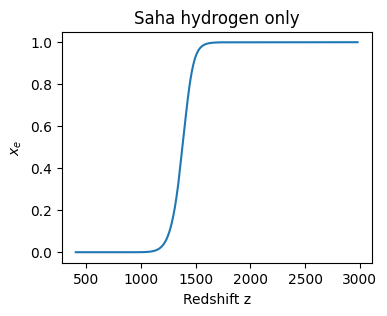

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(4,3))

x_saha_H = np.linspace(-8,-6,1000)
xe_saha_H = xe_sahaH(x_saha_H)

plt.plot(z_of_x(x_saha_H),xe_saha_H)
plt.title('Saha hydrogen only')
plt.xlabel('Redshift z')
plt.ylabel('$x_e$')
#plt.yscale('log')

### Recombination Saha with H and He

In [11]:
chi_0 = 24.5874*u.eV*eV_to_K  #  He to He+ ionization energy
chi_1 = 54.42279*u.eV*eV_to_K  # He+ to He++ ionization energy
Yp = 0.24  # Helium fraction

def fe_sahaHHe(vars,x):
    cst1 = 2*1/nb(x)*(cst.m_e*Tb(x)/(2*np.pi))**(3/2)*np.exp(-chi_0/Tb(x))*cst.k_B**(3/2)/cst.hbar**3
    cst2 = 4*1/nb(x)*(cst.m_e*Tb(x)/(2*np.pi))**(3/2)*np.exp(-chi_1/Tb(x))*cst.k_B**(3/2)/cst.hbar**3
    cst3 = 1/nb(x)*(cst.m_e*Tb(x)/(2*np.pi))**(3/2)*np.exp(-epsilon_0/Tb(x))*cst.k_B**(3/2)/cst.hbar**3

    xHp,xHep,xHepp = vars  # x_H, x_He+, x_He++

    fe = (2*xHepp+xHep)*Yp/4+xHp*(1-Yp)

    eq1 = fe*xHep-(1-xHep-xHepp)*cst1.cgs.value
    eq2 = fe*xHepp-xHep*cst2.cgs.value
    eq3 = fe*xHp-(1-xHp)*cst3.cgs.value

    return [eq1, eq2, eq3]

In [12]:
def xe_sahaHHe(x):
    initial_guess = [1,0,1]  # initial guess for xHp,xHep,xHepp
    Xe = []
    
    if is_iterable(x):
        for x_val in x:
            sols = fsolve(fe_sahaHHe, initial_guess,args=x_val)
            initial_guess = sols
            fe = (2*sols[2]+sols[1])*Yp/4+sols[0]*(1-Yp)
            Xe.append(fe/(1-Yp))
            
    if not is_iterable(x):
        sols = fsolve(fe_sahaHHe, initial_guess,args=x)
        fe = (2*sols[2]+sols[1])*Yp/4+sols[0]*(1-Yp)
        Xe.append(fe/(1-Yp))

    return np.array(Xe)

/Users/waerbeke/miniconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Text(0, 0.5, '$x_e$')

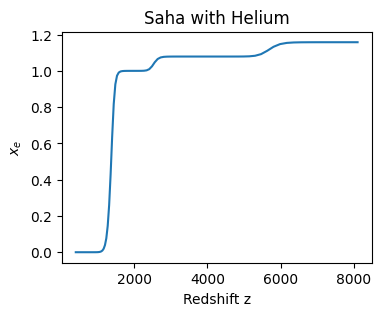

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(4,3))

x_saha_HHe = np.linspace(-9,-6,100)
xe_saha_HHe = xe_sahaHHe(x_saha_HHe)

plt.plot(z_of_x(x_saha_HHe),xe_saha_HHe)
plt.title('Saha with Helium')
plt.xlabel('Redshift z')
plt.ylabel('$x_e$')
#plt.yscale('log')

### Non-equilibrium recombination Peebles 1968

In [14]:
def phi2(Tbx,x):
    phi2 = 0.448*np.log(epsilon_0/Tbx)
    return phi2

def alpha2(Tbx,x):
    alpha2 = 64*np.pi/np.sqrt(27*np.pi)*cst.alpha**2/cst.m_e**2*cst.hbar**2/cst.c*np.sqrt(epsilon_0/Tbx)*phi2(Tbx,x)
    return alpha2.cgs

def beta(Tbx,x):
    beta = alpha2(Tbx,x)*(cst.m_e*Tbx/(2*np.pi))**(3/2)/cst.hbar**3*cst.k_B**(3/2)*np.exp(-epsilon_0/Tbx)
    return beta.cgs

def beta2(Tbx,x):
    beta2 = alpha2(Tbx,x)*(cst.m_e*Tbx/(2*np.pi))**(3/2)/cst.hbar**3*cst.k_B**(3/2)*np.exp(-epsilon_0/(4*Tbx))
    return beta2.cgs

def nH(x,He_flag=False):
    if not He_flag:
        nH = nb(x)  #  hydrogen only
    if He_flag:
        nH = (1-Yp)*nb(x)  #  with helium
    return nH.cgs

def dxe_coll(xe,x,He_flag):
    z = z_of_x(x)
    H = cosmo.H(z).cgs
    Tbx = Tb(x)
    
    L_2s1s = 8.227/u.s
    n_1s = (1-xe)*nH(x,He_flag)
    L_alpha = H*(3*cst.k_B.cgs*epsilon_0)**3/(8*np.pi)**2/n_1s/cst.c.cgs**3/cst.hbar.cgs**3
    
    Cr = (L_2s1s+L_alpha)/(L_2s1s+L_alpha+beta2(Tbx,x))
    
    dxe_coll = Cr/H*(beta(Tbx,x)*(1-xe)-nH(x,He_flag)*alpha2(Tbx,x)*xe**2)
    return dxe_coll

#### Find initial condition for Peebles differential equation by connecting it to Saha values

In [15]:
def xe_init(x,xe_0,He_flag=False):
    if not He_flag:
        xe_init = xe_sahaH(x)-xe_0 # hydrogen only
    if He_flag:
        xe_init = xe_sahaHHe(x)-xe_0 #  with helium
    return xe_init

#### Solving Peebles 1968. The initial condition is set to Saha at sufficiently high redshift, where $x_e=x_{e_0}=0.999$, where equilibrium still applies. Use $\rm He$_$\rm flag$ to choose between H only or Helium.

In [16]:
He_flag = False
# Initial condition
xe_0 = 0.999  # Initial value of xe (to get from Saha)
x_0 = root(xe_init,-7.5,args=(xe_0,He_flag)).x[0] # redshift for initial value of xe
# Generate x values
x_peebles_H = np.linspace(x_0,-0, 100)  # Range and number of points
# Solve the differential equation
xe_peebles_H = odeint(dxe_coll,xe_0,x_peebles_H,args=(He_flag,))[:,0]
# Calculate ne from xe and nH
ne_peebles_H = xe_peebles_H*nH(x_peebles_H,He_flag)

He_flag = True
# Initial condition
xe_0 = 0.999  # Initial value of xe (to get from Saha)
x_0 = root(xe_init,-7.5,args=(xe_0,He_flag)).x[0] # redshift for initial value of xe
# Generate x values
x_peebles_HHe = np.linspace(x_0,-0, 100)  # Range and number of points
# Solve the differential equation
xe_peebles_HHe = odeint(dxe_coll,xe_0,x_peebles_HHe,args=(He_flag,))[:,0]
# Calculate ne from xe and nH
ne_peebles_HHe = xe_peebles_HHe*nH(x_peebles_HHe,He_flag)

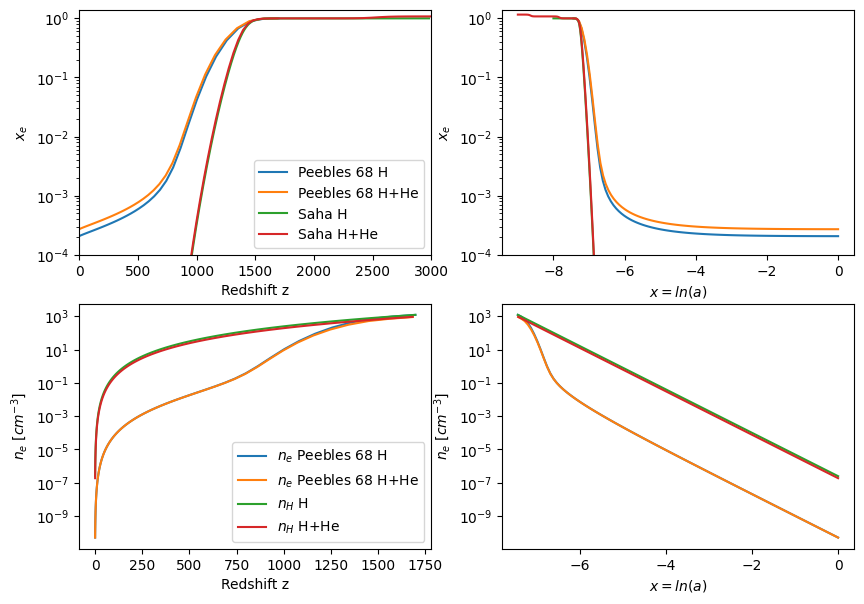

In [17]:
fig, axs = plt.subplots(2,2, figsize=(10,7))

axs[0,0].plot(z_of_x(x_peebles_H),xe_peebles_H,label='Peebles 68 H')
axs[0,0].plot(z_of_x(x_peebles_HHe),xe_peebles_HHe,label='Peebles 68 H+He')
axs[0,0].plot(z_of_x(x_saha_H),xe_saha_H,label='Saha H')
axs[0,0].plot(z_of_x(x_saha_HHe),xe_saha_HHe,label='Saha H+He')
axs[0,0].set_xlim([0,3000])
axs[0,0].set_ylim([1e-4,1.4])
axs[0,0].set_xlabel('Redshift z')
axs[0,0].set_ylabel('$x_e$')
axs[0,0].legend()
axs[0,0].set_yscale('log')

axs[0,1].plot((x_peebles_H),xe_peebles_H,label='Peebles 68 H')
axs[0,1].plot((x_peebles_HHe),xe_peebles_HHe,label='Peebles 68 H+He')
axs[0,1].plot((x_saha_H),xe_saha_H,label='Saha H')
axs[0,1].plot((x_saha_HHe),xe_saha_HHe,label='Saha H+He')
axs[0,1].set_ylim([1e-4,1.4])
axs[0,1].set_xlabel('$x=ln(a)$')
axs[0,1].set_ylabel('$x_e$')
#axs[0,1].legend()
axs[0,1].set_yscale('log')

axs[1,0].plot(z_of_x(x_peebles_H),ne_peebles_H,label='$n_e$ Peebles 68 H')
axs[1,0].plot(z_of_x(x_peebles_HHe),ne_peebles_HHe,label='$n_e$ Peebles 68 H+He')
axs[1,0].plot(z_of_x(x_peebles_H),nH(x_peebles_H,False),label='$n_H$ H')
axs[1,0].plot(z_of_x(x_peebles_HHe),nH(x_peebles_H,True),label='$n_H$ H+He')
axs[1,0].set_xlabel('Redshift z')
axs[1,0].set_ylabel('$n_e~[cm^{-3}]$')
axs[1,0].legend()
axs[1,0].set_yscale('log')

axs[1,1].plot((x_peebles_H),ne_peebles_H,label='$n_e$ Peebles 68 H')
axs[1,1].plot((x_peebles_HHe),ne_peebles_HHe,label='$n_e$ Peebles 68 H+He')
axs[1,1].plot((x_peebles_H),nH(x_peebles_H,False),label='$n_H$ H')
axs[1,1].plot((x_peebles_HHe),nH(x_peebles_H,True),label='$n_H$ H+He')
axs[1,1].set_xlabel('$x=ln(a)$')
axs[1,1].set_ylabel('$n_e~[cm^{-3}]$')
#axs[1,1].legend()
axs[1,1].set_yscale('log')

### Reionization models

#### Model 1 from https://cmb.wintherscoming.no/milestone2.php#Reionization

In [18]:
f_He = Yp/(4*(1-Yp))
z_reion = 8
x_reion = x_of_z(z_reion)
Delta_z_reion = 0.5
z_Hereion = 3.5
x_Hereion = x_of_z(z_Hereion)
Delta_z_Hereion = 0.5

def y_func(z):
    return (1+z)**(3/2)

def Delta_y_func(z,Delta_z):
    return 3/2*np.sqrt(1+z)*Delta_z

def xe_reion(x,He_flag=False):
    z = z_of_x(x)
    xe_reion = (1+f_He)/2*(1+np.tanh((y_func(z_reion)-y_func(z))/Delta_y_func(z_reion,Delta_z_reion)))
    xe_Hereion = 0
    if He_flag:
        xe_Hereion = f_He/2*(1+np.tanh((z_Hereion-z)/Delta_z_Hereion))
    return xe_reion+xe_Hereion

Text(0, 0.5, '$n_e~[cm^{-3}]$')

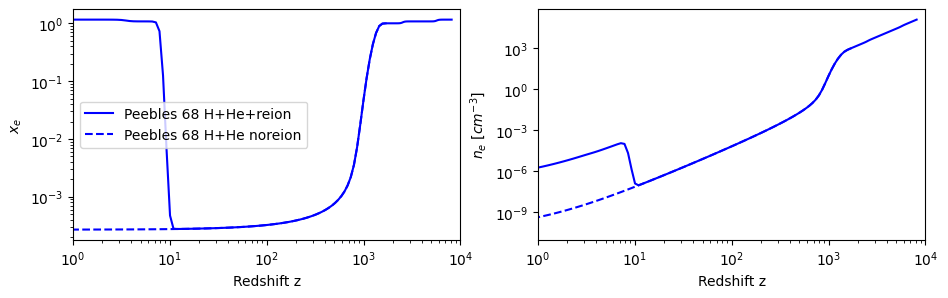

In [19]:
fig, axs = plt.subplots(1,2, figsize=(11,3))

axs[0].plot(z_of_x(x_peebles_HHe),(xe_peebles_HHe+xe_reion(x_peebles_HHe,True)),c='b',label='Peebles 68 H+He+reion')
axs[0].plot(z_of_x(x_peebles_HHe),(xe_peebles_HHe+0*xe_reion(x_peebles_HHe,True)),c='b',linestyle='--',label='Peebles 68 H+He noreion')

axs[0].plot(z_of_x(x_saha_HHe[0:52]),xe_saha_HHe[0:52],c='b')
axs[0].set_xlim([1,1e4])
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('Redshift z')
axs[0].set_ylabel('$x_e$')
axs[0].legend()

axs[1].plot(z_of_x(x_peebles_HHe),(xe_peebles_HHe+xe_reion(x_peebles_HHe,True))*nH(x_peebles_HHe,True),c='b')
axs[1].plot(z_of_x(x_peebles_HHe),(xe_peebles_HHe+0*xe_reion(x_peebles_HHe,True))*nH(x_peebles_HHe,True),c='b',linestyle='--')

axs[1].plot(z_of_x(x_saha_HHe[0:52]),xe_saha_HHe[0:52]*nH(x_saha_HHe[0:52],True),c='b')
axs[1].set_xlim([1,1e4])
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('Redshift z')
axs[1].set_ylabel('$n_e~[cm^{-3}]$')

#### Model 2 TBD from https://academic.oup.com/mnras/article/371/2/867/1033021, used in https://arxiv.org/pdf/2208.03816.pdf

### Setup the $x_e$ and $n_e$ interpolations on the Peebles 68 recombination model

In [20]:
xe_peebles_H_interp = interp1d(x_peebles_H,np.log10(xe_peebles_H), kind='cubic',fill_value='extrapolate')
xe_peebles_HHe_interp = interp1d(x_peebles_HHe,np.log10(xe_peebles_HHe), kind='cubic',fill_value='extrapolate')
ne_peebles_H_interp = interp1d(x_peebles_H,np.log10(ne_peebles_H.value), kind='cubic',fill_value='extrapolate')
ne_peebles_HHe_interp = interp1d(x_peebles_HHe,np.log10(ne_peebles_HHe.value), kind='cubic',fill_value='extrapolate')

### Optical depth calculation

In [21]:
def dtau(xp,He_flag=False,reion_flag=False):
    zp = z_of_x(xp)
    if not He_flag:
        dtau = -cst.c.cgs*10**ne_peebles_H_interp(xp)/u.cm**3*cst.sigma_T.cgs/cosmo.H(zp).cgs
    if He_flag:
        dtau = -cst.c.cgs*10**ne_peebles_HHe_interp(xp)/u.cm**3*cst.sigma_T.cgs/cosmo.H(zp).cgs
    if reion_flag:
        ddtau = -cst.c.cgs*xe_reion(xp,He_flag)*nH(xp,He_flag).value/u.cm**3*cst.sigma_T.cgs/cosmo.H(zp).cgs
        dtau = dtau+ddtau
    return dtau

In [22]:
tau_noreion_HHe = np.zeros_like(xe_peebles_HHe)
tau_reion_HHe = np.zeros_like(xe_peebles_HHe)

He_flag = True
reion_flag = False
for i in range(x_peebles_HHe.size-1):
    tau_noreion_HHe[::-1][i+1] = tau_noreion_HHe[::-1][i]+quad(dtau,x_peebles_HHe[::-1][i],x_peebles_HHe[::-1][i+1],args=(He_flag,reion_flag))[0]

He_flag = True
reion_flag = True
for i in range(x_peebles_HHe.size-1):
    tau_reion_HHe[::-1][i+1] = tau_reion_HHe[::-1][i]+quad(dtau,x_peebles_HHe[::-1][i],x_peebles_HHe[::-1][i+1],args=(He_flag,reion_flag))[0]


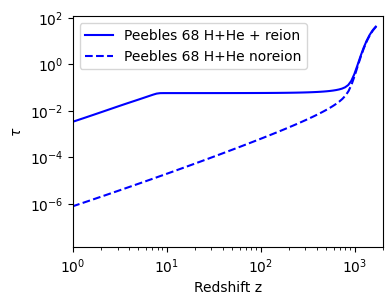

In [23]:
fig, axs = plt.subplots(1,1, figsize=(4,3))

plt.plot(z_of_x(x_peebles_HHe),tau_reion_HHe,c='b',label='Peebles 68 H+He + reion')
plt.plot(z_of_x(x_peebles_H),tau_noreion_HHe,c='b',linestyle='--',label='Peebles 68 H+He noreion')

plt.xlabel('Redshift z')
plt.ylabel('$\\tau$')
plt.xlim([1,2e3])
plt.legend()
plt.xscale('log')
plt.yscale('log')

<h2><center style="font-size: 32px">II- $X_e$ and $T_b$</center></h2>

### This section calculates the physics of recombination and the late time of $X_e$ and $T_b$ using the coupled ODEs system photon-baryons.

### The system being solved is $\frac{d x_e}{dx}=F(x_e,y_T,x)$ and $\frac{dy_T}{dx}=G(x_e,y_T,x)$ where $y_T=\frac{T_b}{T_\gamma}-1$ is used as the variable for the baryon temperature

In [24]:
Yp = 0.24
def dxe_eq(xe,yT,x,He_flag=False):
    z = z_of_x(x)
    H = cosmo.H(z).cgs
    Tbx = cosmo.Tcmb0*np.exp(-x)*(yT+1)
    
    L_2s1s = 8.227/u.s
    n_1s = (1-xe)*nH(x,He_flag)
    L_alpha = H*(3*cst.k_B.cgs*epsilon_0)**3/(8*np.pi)**2/n_1s/cst.c.cgs**3/cst.hbar.cgs**3
    
    Cr = (L_2s1s+L_alpha)/(L_2s1s+L_alpha+beta2(Tbx,x))
    
    dxe_eq = Cr/H*(beta(Tbx,x)*(1-xe)-nH(x,He_flag)*alpha2(Tbx,x)*xe**2)
    return dxe_eq

In [25]:
def dyT_eq(xe,yT,x,He_flag=False):
    z = z_of_x(x)
    mu = cst.m_p.cgs
    R = 4*cosmo.Ogamma0*np.exp(-x)/(3*cosmo.Ob0)
    
    dtaudx = -cst.c.cgs*xe*nH(x,He_flag).value/u.cm**3*cst.sigma_T.cgs/cosmo.H(z).cgs
        
    dyT_eq = -(yT+1)+2*mu/cst.m_e.cgs*R*dtaudx*yT
    return dyT_eq

In [26]:
# Define the system of differential equations
def dxedTb(y,x,He_flag=False):
    xe, yT = y  # Unpack the variables
    dxedx = dxe_eq(xe,yT,x,He_flag)
    dyTdx = dyT_eq(xe,yT,x,He_flag)
    return [dxedx,dyTdx]

In [27]:
# Initial condition
xe_0 = 0.999  # Initial value of xe (to get from Saha)
He_flag = False
x_0 = root(xe_init,-7.5,args=(xe_0,He_flag)).x[0] # redshift for initial value of xe
yT_0 = 0.
xeTb_0 = [xe_0,yT_0]
x_xeTb_H = np.linspace(x_0,-0, 100)

# Solving the differential equations
xeTb_sol_H = odeint(dxedTb,xeTb_0,x_xeTb_H,atol=1e-12, rtol=1e-12,args=(He_flag,))

In [28]:
# Initial condition
xe_0 = 0.999  # Initial value of xe (to get from Saha)
He_flag = True
x_0 = root(xe_init,-7.5,args=(xe_0,He_flag)).x[0] # redshift for initial value of xe
yT_0 = 0.
xeTb_0 = [xe_0,yT_0]
x_xeTb_HHe = np.linspace(x_0,-0, 100)

# Solving the differential equations
xeTb_sol_HHe = odeint(dxedTb,xeTb_0,x_xeTb_HHe,atol=1e-12, rtol=1e-12,args=(He_flag,))

In [29]:
xe_sol_H,yT_sol_H = xeTb_sol_H[:,0],xeTb_sol_H[:,1]
Tb_sol_H = cosmo.Tcmb0*np.exp(-x_xeTb_H)*(yT_sol_H+1)

xe_sol_HHe,yT_sol_HHe = xeTb_sol_HHe[:,0],xeTb_sol_HHe[:,1]
Tb_sol_HHe = cosmo.Tcmb0*np.exp(-x_xeTb_HHe)*(yT_sol_HHe+1)

Tcmb = cosmo.Tcmb0*np.exp(-x_xeTb_HHe)

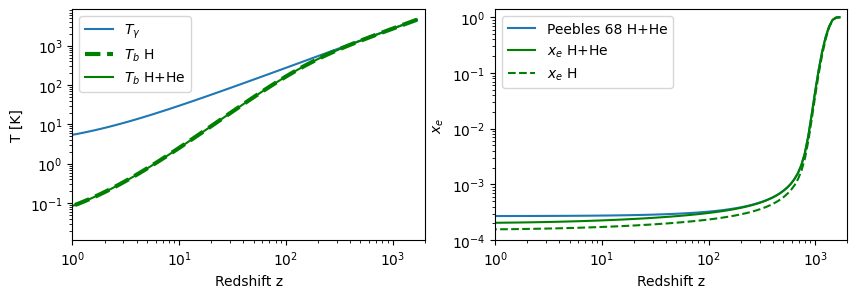

In [49]:
fig, axs = plt.subplots(1,2, figsize=(10,3))

axs[0].plot(z_of_x(x_xeTb_HHe),Tcmb,label='$T_\gamma$')
axs[0].plot(z_of_x(x_xeTb_H),Tb_sol_H,c='g',linestyle='--',linewidth=3,label='$T_b$ H')
axs[0].plot(z_of_x(x_xeTb_HHe),Tb_sol_HHe,c='g',label='$T_b$ H+He')
axs[0].set_ylabel('T [K]')
axs[0].set_xlabel('Redshift z')
axs[0].set_xlim([1,2e3])
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend()

axs[1].plot(z_of_x(x_peebles_HHe),xe_peebles_HHe,label='Peebles 68 H+He')
axs[1].plot(z_of_x(x_xeTb_HHe),xe_sol_HHe,c='g',label='$x_e$ H+He')
axs[1].plot(z_of_x(x_xeTb_H),xe_sol_H,c='g',linestyle='--',label='$x_e$ H')
axs[1].set_xlabel('Redshift z')
axs[1].set_ylabel('$x_e$')
axs[1].set_xlim([1,2e3])
axs[1].set_ylim([1e-4,1.4])
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].legend()

<h2><center style="font-size: 32px">III- Energy injection models</center></h2>

### PBH based on https://arxiv.org/pdf/2208.03816.pdf

### Particle decay and annihilation based on https://arxiv.org/pdf/1912.07409.pdf

#### $C_r(x_e,t_T,x)$ function which controls the reduction of energy injection in case of atomic exitation (eq 3.5 in https://arxiv.org/pdf/1912.07409.pdf)

In [31]:
def Cr(xe,yT,x,He_flag=False):
    z = z_of_x(x)
    H = cosmo.H(z).cgs
    Tbx = cosmo.Tcmb0*np.exp(-x)*(yT+1)
    
    L_2s1s = 8.227/u.s
    n_1s = (1-xe)*nH(x,He_flag)
    L_alpha = H*(3*cst.k_B.cgs*epsilon_0)**3/(8*np.pi)**2/n_1s/cst.c.cgs**3/cst.hbar.cgs**3
    
    Cr = (L_2s1s+L_alpha)/(L_2s1s+L_alpha+beta2(Tbx,x))
    return Cr.cgs

#### Energy injection models
##### Particle decay with $\rm t\_decay$
##### Particle annihilation with $p_{\rm ann}=f_{\rm eff}\frac{\langle \sigma v\rangle}{m_\chi}$

In [32]:
t_decay = 1e26*u.s
p_ann = 1.9e-5*u.m**3/u.s/u.kg

def dEdVdt_inj(x,inj_model):
    z = z_of_x(x)
    f_chi = 1
    f_eff = 0.1
    if inj_model == 'decay':
        dEdVdt_inj = f_eff*f_chi*(1+z)**3*cosmo.Odm(0)*cosmo.critical_density(0)*cst.c**2*np.exp(-cosmo.age(z)/t_decay)/t_decay
    if inj_model == 'ann':
        dEdVdt_inj = f_chi*(1+z)**6*(cosmo.Odm(0)*cosmo.critical_density(0))**2*cst.c**2*p_ann.cgs
    return dEdVdt_inj.to(u.erg/u.s/u.cm**3)

def dxe_inj(xe,yT,x,inj_model):
    z = z_of_x(x)
    H = cosmo.H(z).cgs
    dxe_inj = -1/nH(x)*(1/E_Hion+(1-Cr(xe,yT,x))/E_Lya)*dEdVdt_inj(x,inj_model)/H
    return dxe_inj.cgs

def yT_inj(xe,yT,x,inj_model):
    z = z_of_x(x)
    H = cosmo.H(z).cgs
    yT_inj = 2/cosmo.Tcmb0*np.exp(x)/(3*cst.k_B.cgs)/nH(x)/(1+0*Yp/(4*(1-Yp))+xe)*dEdVdt_inj(x,inj_model)/H
    return yT_inj

### Solving $\frac{d x_e}{dx}=F(x_e,y_T,x)$ and $\frac{dy_T}{dx}=G(x_e,y_T,x)$ with energy injection

In [37]:
Yp = 0.24
def dxe_eq_inj(xe,yT,x,inj_model,He_flag):
    z = z_of_x(x)
    H = cosmo.H(z).cgs
    Tbx = cosmo.Tcmb0*np.exp(-x)*(yT+1)
    
    L_2s1s = 8.227/u.s
    n_1s = (1-xe)*nH(x,He_flag)
    L_alpha = H*(3*cst.k_B.cgs*epsilon_0)**3/(8*np.pi)**2/n_1s/cst.c.cgs**3/cst.hbar.cgs**3
    
    Cr = (L_2s1s+L_alpha)/(L_2s1s+L_alpha+beta2(Tbx,x))
    
    dxe_eq_inf = Cr/H*(beta(Tbx,x)*(1-xe)-nH(x,He_flag)*alpha2(Tbx,x)*xe**2)-dxe_inj(xe,yT,x,inj_model)
    return dxe_eq_inf

In [38]:
def dyT_eq_inj(xe,yT,x,inj_model,He_flag):
    z = z_of_x(x)
    mu = cst.m_p.cgs
    R = 4*cosmo.Ogamma0*np.exp(-x)/(3*cosmo.Ob0)
    
    dtaudx = -cst.c.cgs*xe*nH(x,He_flag).value/u.cm**3*cst.sigma_T.cgs/cosmo.H(z).cgs
        
    dyT_eq_inj = -(yT+1)+2*mu/cst.m_e.cgs*R*dtaudx*yT+yT_inj(xe,yT,x,inj_model)
    return dyT_eq_inj

In [39]:
# Define the system of differential equations
def dxedTb_inj(y,x,inj_model,He_flag):
    xe, yT = y  # Unpack the variables
    dxedx_inj = dxe_eq_inj(xe,yT,x,inj_model,He_flag)
    dyTdx_inj = dyT_eq_inj(xe,yT,x,inj_model,He_flag)
    return [dxedx_inj,dyTdx_inj]

In [45]:
#  Helium recom flag
He_flag = True

# Energy injection model choice
inj_model = 'decay'
#inj_model = 'ann'

# Initial condition
xe_0 = 0.999  # Initial value of xe (to get from Saha)
x_0 = root(xe_init,-7.5,args=(xe_0,He_flag)).x[0] # redshift for initial value of xe
yT_0 = 0.
xeTb_0 = [xe_0,yT_0]
x_xeTb_inj_HHe = np.linspace(x_0,-0, 100)

xeTb_inj_sol_HHe = odeint(dxedTb_inj,xeTb_0,x_xeTb_inj_HHe,atol=1e-12, rtol=1e-12,args=(inj_model,He_flag))

In [47]:
xe_inj_sol_HHe,yT_inj_sol_HHe = xeTb_inj_sol_HHe[:,0],xeTb_inj_sol_HHe[:,1]
Tb_inj_sol_HHe = cosmo.Tcmb0*np.exp(-x_xeTb_inj_HHe)*(yT_inj_sol_HHe+1)

xe_sol_HHe,yT_sol_HHe = xeTb_sol_HHe[:,0],xeTb_sol_HHe[:,1]
Tb_sol_HHe = cosmo.Tcmb0*np.exp(-x_xeTb_HHe)*(yT_sol_HHe+1)

Tcmb = cosmo.Tcmb0*np.exp(-x_xeTb_HHe)

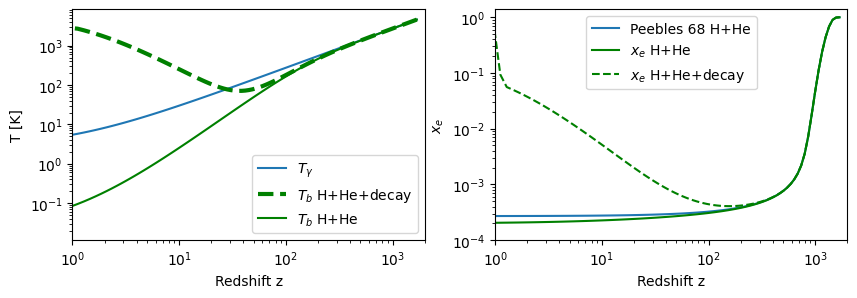

In [48]:
fig, axs = plt.subplots(1,2, figsize=(10,3))

axs[0].plot(z_of_x(x_xeTb_HHe),Tcmb,label='$T_\gamma$')
axs[0].plot(z_of_x(x_xeTb_inj_HHe),Tb_inj_sol_HHe,c='g',linestyle='--',linewidth=3,label='$T_b$ H+He+'+inj_model)
axs[0].plot(z_of_x(x_xeTb_HHe),Tb_sol_HHe,c='g',label='$T_b$ H+He')
axs[0].set_ylabel('T [K]')
axs[0].set_xlabel('Redshift z')
axs[0].set_xlim([1,2e3])
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend()

axs[1].plot(z_of_x(x_peebles_HHe),xe_peebles_HHe,label='Peebles 68 H+He')
axs[1].plot(z_of_x(x_xeTb_HHe),xe_sol_HHe,c='g',label='$x_e$ H+He')
axs[1].plot(z_of_x(x_xeTb_inj_HHe),xe_inj_sol_HHe,c='g',linestyle='--',label='$x_e$ H+He+'+inj_model)
axs[1].set_xlabel('Redshift z')
axs[1].set_ylabel('$x_e$')
axs[1].set_xlim([1,2e3])
axs[1].set_ylim([1e-4,1.4])
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].legend()